In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/code/libs

/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/code/libs


In [3]:
import sys
sys.path.append("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/code/libs/")

In [4]:
import matplotlib.pyplot as plt
# from lr_finder import LRFinder
import data_processing
import get_models
import data_generator
import data_augmentation
import predict
from sklearn.utils import shuffle
import pandas as pd

import keras
import tensorflow as tf
from keras import layers, Input
from keras.utils import np_utils 
from sklearn.model_selection import train_test_split


from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation,Average
from tensorflow.keras.applications import VGG16, ResNet50, VGG19, ResNet50V2, MobileNetV2, MobileNetV2
from tensorflow.keras.optimizers import Adam, Adamax
from keras.models import load_model, Model
from tensorflow.keras import regularizers


In [5]:
#Import the libraries
import zipfile
import os
import shutil
import numpy as np
from imutils import paths

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/WorkSpace/AI_Research/datasets/RAFDB/basic/Image/aligned.zip", 'r') #Opens the zip file in read mode
zip_ref.extractall('/dataset') 
zip_ref.close()

In [6]:

data_processing.Get_raf_aligned("/dataset/aligned/","/content/drive/MyDrive/WorkSpace/AI_Research/datasets/RAFDB/basic/EmoLabel/list_patition_label.txt" )

'Get aligned!!!'

In [7]:
emotionsraf = ["Surprise", "Fear", "Disgust", "Happiness", "Sadness", "Anger","Neutral"]
X_train = np.load("/content/drive/MyDrive/WorkSpace/AI_Research/datasets/RAFDB/raf_aligned_images.npy")
y_train = np.load("/content/drive/MyDrive/WorkSpace/AI_Research/datasets/RAFDB/raf_aligned_labels.npy")
# X_test = np.load("/content/drive/MyDrive/WorkSpace/AI_Research/datasets/RAFDB/raf_aligned_images1.npy")
# y_test = np.load("/content/drive/MyDrive/WorkSpace/AI_Research/datasets/RAFDB/raf_aligned_labels.npy")

In [8]:
# Offline augmentation
X_train, y_train, X_test, y_test= data_processing.split_data(X_train,y_train)
X_train, y_train, X_val, y_val= data_processing.split_data(X_train,y_train)
# X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 5, number_aug = 8)
X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 1, number_aug = 8)
X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 2, number_aug = 3)
X_train, y_train = data_augmentation.aug_offline(X_train, y_train, num_class = 5, number_aug = 3)
#Split Data Train and Val

X_train, y_train = shuffle(X_train, y_train)

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(19071, 48, 48, 1)
(1381, 48, 48, 1)
(1534, 48, 48, 1)


In [10]:
img_size = 48

In [11]:
params_train = {'shape': (img_size,img_size),
          'n_channel' : 1,
          'n_classes': 7,
          'shuffle': True,
          'augmentation': True}
params_val = {'shape': (img_size,img_size),
          'n_channel' : 1,
          'n_classes': 7,
          'shuffle': None,
          'augmentation': None}         

train_ds = data_generator.DataGenerator(X_train, y_train, **params_train ).to_dataset(data_type = "train")
val_ds = data_generator.DataGenerator(X_val, y_val, **params_val).to_dataset(data_type = "val")
test_ds = data_generator.DataGenerator(X_test, y_test, **params_val).to_dataset(data_type = "test", batch_size = 1)

In [12]:
# Create input shape
img_size_target = img_size # 224,244,3
img_input = Input(shape=(img_size_target, img_size_target, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])

In [13]:
model = get_models.Pre_train_model(ResNet50, img_conc, None)


model.compile(loss ="categorical_crossentropy", optimizer =Adamax(3e-4), metrics=["accuracy"])
# EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0 , verbose =1)

checkpoint_filepath = ("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/RAFDBnew_V5.hdf5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose= 1,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True, save_weights_only = True)


94781440/94765736 [==============================] - 0s 0us/step


In [14]:
H = model.fit(train_ds, validation_data=val_ds, steps_per_epoch=2100,
              epochs=50, verbose = 1, callbacks = [reduce_lr,model_checkpoint ])

Epoch 1/50
2100/2100 [==============================] - ETA: 0s - loss: 2.2162 - accuracy: 0.4536
Epoch 1: val_accuracy improved from -inf to 0.63577, saving model to /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/RAFDBnew_V5.hdf5
2100/2100 [==============================] - 213s 93ms/step - loss: 2.2162 - accuracy: 0.4536 - val_loss: 1.7623 - val_accuracy: 0.6358 - lr: 3.0000e-04
Epoch 2/50
2100/2100 [==============================] - ETA: 0s - loss: 1.7201 - accuracy: 0.6338
Epoch 2: val_accuracy improved from 0.63577 to 0.71470, saving model to /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/RAFDBnew_V5.hdf5
2100/2100 [==============================] - 192s 91ms/step - loss: 1.7201 - accuracy: 0.6338 - val_loss: 1.4888 - val_accuracy: 0.7147 - lr: 3.0000e-04
Epoch 3/50
2100/2100 [==============================] - ETA: 0s - loss: 1.4661 - accuracy: 0.7002
Epoch 3: val_accuracy improved from 0.71470 to 0.72339, saving model to /content/drive/MyDrive/

In [15]:
model.evaluate(test_ds)

1534/1534 [==============================] - 19s 12ms/step - loss: 1.1852 - accuracy: 0.7738


[1.1852065324783325, 0.7737939953804016]

In [ ]:
images , test_labels = predict.get_imgs_test(test_ds)
get_models.Confusion_Matrix(model , images, test_labels ,  emotionsraf, mode = True)

In [17]:
model = get_models.Pre_train_model(VGG16, img_conc, None)

# model.load_weights("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/RAFDBnew_V3.hdf5")


model.compile(loss ="categorical_crossentropy", optimizer =Adamax(3e-4), metrics=["accuracy"])
# EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0 , verbose =1)

checkpoint_filepath = ("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/RAFDBnew_v6.hdf5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose= 1,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True, save_weights_only = True)

H = model.fit(train_ds, validation_data=test_ds, steps_per_epoch=2100,
              epochs=50, verbose = 1, callbacks = [reduce_lr,model_checkpoint ])

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/50
2100/2100 [==============================] - ETA: 0s - loss: 1.7969 - accuracy: 0.3974
Epoch 1: val_accuracy improved from -inf to 0.63755, saving model to /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/RAFDBnew_v6.hdf5
2100/2100 [==============================] - 176s 83ms/step - loss: 1.7969 - accuracy: 0.3974 - val_loss: 1.2199 - val_accuracy: 0.6375 - lr: 3.0000e-04
Epoch 2/50
2100/2100 [==============================] - ETA: 0s - loss: 1.2472 - accuracy: 0.6085
Epoch 2: val_accuracy improved from 0.63755 to 0.69883, saving model to /content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/RAFDBnew_v6.hdf5
2100/2100 [==============================] - 174s 83ms/step - loss: 1.2472 - accuracy: 0.6085 - val_loss: 1.0004 - val_accuracy: 0.6988 - lr: 3.0000e-04
Epoch 3/50
2100/2100 [==============================] - ETA: 0s - loss: 1.0242 - accuracy: 0.6849
Epoch 3: val_accuracy did not 

In [ ]:
# model = get_models.Pre_train_model(ResNet50, img_conc, None)

# model.compile(loss ="categorical_crossentropy", optimizer =Adamax(2e-4), metrics=["accuracy"])
# model.load_weights("/content/drive/MyDrive/WorkSpace/AI_Research/Emotion/checkpoints/RAFDBnew_V5.hdf5")

In [22]:
model.evaluate(test_ds)

1534/1534 [==============================] - 10s 6ms/step - loss: 0.8393 - accuracy: 0.8018


[0.8392712473869324, 0.8018252849578857]

In [23]:
images , test_labels = predict.get_imgs_test(test_ds)

+ precision = 0.719
+ recall = 0.712
+ f1_score = 0.715


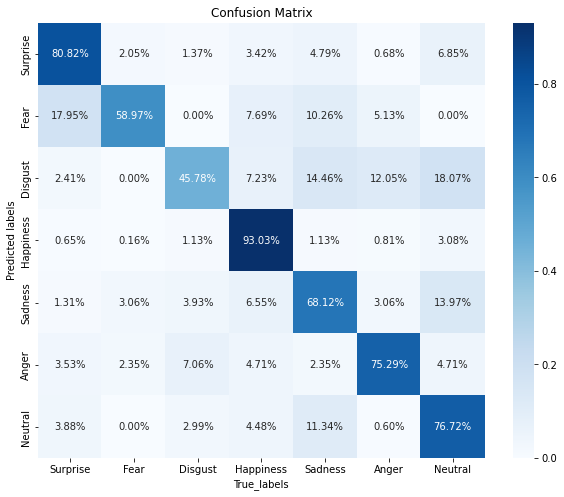

In [24]:
get_models.Confusion_Matrix(model , images, test_labels ,  emotionsraf, mode = True)